# Несбалансированные выборки. Практическая работа

## Цель практической работы

Научиться обрабатывать несбалансированные данные и обучать модели машинного обучения на таких данных.

## Что входит в работу


1. Загрузить данные и провести разведочный анализ.
2. Разделить данные на обучающую и тестовую выборки.
3. Подготовить данные для моделирования.
4. Сбалансировать данные методом SMOTE и обучить модель машинного обучения.
5. Обучить модель машинного обучения с использованием весов классов и кросс-валидации.
6. Сравнить метрики качества четырёх моделей.




## Что оценивается 

- Выполнены все этапы работы.
- Не допущена утечка данных при разделении выборок и подготовке данных.
- Данные корректным образом сбалансированы.
- Модели не переобучены.


## Как отправить работу на проверку

Скачайте файл с заданиями в материалах, откройте его через Jupyter Notebook и выполните задания. Сохраните изменения при помощи опции Save and Checkpoint из вкладки меню File или кнопки Save and Checkpoint на панели инструментов. Отправьте через форму ниже итоговый файл Jupyter Notebook (в формате .ipynb) или ссылку на него.


# Задача

Пусть у нас имеется некоторый набор данных `german_credit_data.csv` о заёмщиках банка:

* Age — возраст заёмщика.
* Sex — пол заёмщика.
* Job — тип работы заёмщика.
* Housing — тип жилья заёмщика.
* Saving accounts — объём средств на сберегательных счетах заёмщика.
* Checking account — объём средств на основном счёте заёмщика.
* Credit amount — размер кредита. 
* Duration — срок кредита (в месяцах).
* Purpose — цель кредита.
* Risk — таргет, допустил ли заёмщик просрочку платежей по кредиту.

Решите задачу классификации заёмщиков, чтобы банк умел заранее предсказывать просрочку платежей по кредиту. 



In [116]:
%reload_ext autoreload
%autoreload 2

In [117]:
import warnings

import model_funcs

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.ensemble import ExtraTreesClassifier
from imblearn.over_sampling import SMOTE, ADASYN 
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier, EasyEnsembleClassifier
%matplotlib inline

warnings.filterwarnings("ignore", category=FutureWarning)

# Задание 1

Загрузите датасет и выполните разведочный анализ данных. Сделайте выводы о найденных закономерностях, особенностях и других свойствах данных, которые вы обнаружите.

xgboost, catboost + всё из имблерна

In [118]:
df = pd.read_csv("german_credit_data.csv")
df.rename(
    columns={"Risk": "target"},
    inplace=True,
)
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,target
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   target            1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.2+ KB


In [120]:
# report = ProfileReport(df)
# report.to_notebook_iframe()

### **1.1. Небольшой эксперимент с катбустом на входе без всяких-яких.**

In [121]:
df_exp = df.copy()

df_exp.fillna("unknown", inplace=True)
df_exp.Job = df_exp.Job.astype(str)

In [122]:
X_exp = df_exp.drop("target", axis=1)
y_exp = df_exp["target"]

In [123]:
X_train_exp, X_test_exp, y_train_exp, y_test_exp = train_test_split(
    X_exp, y_exp, test_size=0.2, random_state=137
)

In [124]:
cat_features = [
    "Sex",
    "Housing",
    "Job",
    "Saving accounts",
    "Checking account",
    "Purpose",
]
cb = CatBoostClassifier(
    iterations=100,
    cat_features=cat_features,
    random_seed=137,
    eval_metric="AUC",
    logging_level="Silent",
)

model_funcs.get_roc_auc_special(
    cb, X_train_exp, y_train_exp, X_test_exp, y_test_exp, "Initial CatBoostCl"
)

ROC-AUC with Initial CatBoostCl        : 76.64%


('Initial CatBoostCl', 0.7664233576642335)

**Запомним это значение — 76.64%. Очень хорошее значение. Очень. Будем пробовать его переплюнуть всяческими методами.**

# Задание 2

Разделите датасет на обучающую и тестовую выборки в пропорции 80:20. Разделение должно быть стратифицированным по таргету Risk.

В этом и следующих заданиях используйте random_state = 1.

**Сразу закодирую таргет, чтобы потом не возвращаться:**

In [125]:
df.target = (df.target == "good").astype(int)
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,target
0,67,male,2,own,NaN,little,1169,6,radio/TV,1
1,22,female,2,own,little,moderate,5951,48,radio/TV,0
2,49,male,1,own,little,NaN,2096,12,education,1
3,45,male,2,free,little,little,7882,42,furniture/equipment,1
4,53,male,2,free,little,little,4870,24,car,0


In [126]:
X = df.drop("target", axis=1)
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=137, stratify=y
)

# Задание 3

Проведите этап очистки и подготовки данных (data preparation) и подготовьте данные к моделированию.

**Используем LabelEncoder, т.к. мы будем использовать леса, а им по барабану значение категории.**

In [127]:
cat_features = ["Sex", "Housing", "Job", "Saving accounts", "Checking account", "Purpose"]

le = LabelEncoder()
for col in cat_features:
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])

X_train.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
211,45,0,1,1,4,3,3835,36,5
93,20,1,2,2,4,2,3617,24,4
414,35,0,2,1,4,0,1381,24,1
687,30,1,2,0,1,1,2862,36,1
346,23,1,2,1,0,1,882,13,5


Учитывая, что признак `Credit amount` сильно смещён, прологарифмируем его, чтобы привести к равномерному распределению.

In [128]:
X_train['Credit amount'] = np.log1p(X_train['Credit amount'])
X_test['Credit amount'] = np.log1p(X_test['Credit amount'])
X_train.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
211,45,0,1,1,4,3,8.252185,36,5
93,20,1,2,2,4,2,8.193677,24,4
414,35,0,2,1,4,0,7.231287,24,1
687,30,1,2,0,1,1,7.959625,36,1
346,23,1,2,1,0,1,6.783325,13,5


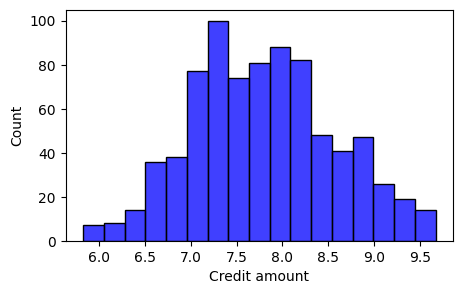

In [129]:
plt.figure(figsize=(5, 3))
sns.histplot(X_train['Credit amount'], color='blue');

In [130]:
knn_imputer = KNNImputer(n_neighbors=5, weights="uniform")

X_train_imputed = knn_imputer.fit_transform(X_train)
X_test_imputed = knn_imputer.transform(X_test)

X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.columns)

X_train_imputed.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,45.0,0.0,1.0,1.0,4.0,3.0,8.252185,36.0,5.0
1,20.0,1.0,2.0,2.0,4.0,2.0,8.193677,24.0,4.0
2,35.0,0.0,2.0,1.0,4.0,0.0,7.231287,24.0,1.0
3,30.0,1.0,2.0,0.0,1.0,1.0,7.959625,36.0,1.0
4,23.0,1.0,2.0,1.0,0.0,1.0,6.783325,13.0,5.0


In [131]:
X_train_imputed.isna().sum()

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
dtype: int64

# Задание 4

Сбалансируйте обучающую выборку методом SMOTE и обучите модель RandomForestClassifier. Подберите оптимальные гиперпараметры с помощью GridSearch. Посчитайте метрику ROC-AUC на тестовой выборке.

In [132]:
os = SMOTE(random_state=137)
adasyn = ADASYN(random_state=137)
enn = SMOTEENN(random_state=137)
st = SMOTETomek(random_state=137)


X_train_os, y_train_os = os.fit_resample(X_train_imputed, y_train)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_imputed, y_train)
X_train_enn, y_train_enn = enn.fit_resample(X_train_imputed, y_train)
X_train_st, y_train_st = st.fit_resample(X_train_imputed, y_train)


In [133]:
model_funcs.get_roc_auc_cb(X_train_os, y_train_os, X_test_imputed, y_test, "SMOTE")
model_funcs.get_roc_auc_cb(X_train_adasyn, y_train_adasyn, X_test_imputed, y_test, "ADASYN")
model_funcs.get_roc_auc_cb(X_train_enn, y_train_enn, X_test_imputed, y_test, "SMOTEENN")
model_funcs.get_roc_auc_cb(X_train_st, y_train_st, X_test_imputed, y_test, "SMOTETomek")

ROC-AUC with SMOTE                     : 73.17%
ROC-AUC with ADASYN                    : 74.54%
ROC-AUC with SMOTEENN                  : 74.50%
ROC-AUC with SMOTETomek                : 72.86%


('SMOTETomek', 0.7285714285714286)

In [134]:
model_funcs.get_roc_auc_xgb(X_train_os, y_train_os, X_test_imputed, y_test, "SMOTE")
model_funcs.get_roc_auc_xgb(X_train_adasyn, y_train_adasyn, X_test_imputed, y_test, "ADASYN")
model_funcs.get_roc_auc_xgb(X_train_enn, y_train_enn, X_test_imputed, y_test, "SMOTEENN")
model_funcs.get_roc_auc_xgb(X_train_st, y_train_st, X_test_imputed, y_test, "SMOTETomek")

ROC-AUC with SMOTE                     : 75.30%
ROC-AUC with ADASYN                    : 76.85%
ROC-AUC with SMOTEENN                  : 74.90%
ROC-AUC with SMOTETomek                : 75.62%


('SMOTETomek', 0.7561904761904762)

**Неожиданно, прямо скажем. В очередной раз убеждаюсь, что время потрачено впустую.** :)

**Ну, и напоследок:**

In [135]:
bbc = BalancedBaggingClassifier(
    estimator=ExtraTreesClassifier(), random_state=137, n_estimators=100, n_jobs=-1
)
eec = EasyEnsembleClassifier(
    estimator=ExtraTreesClassifier(), random_state=137, n_estimators=100, n_jobs=-1
)

model_funcs.get_roc_auc_special(
    bbc, X_train_imputed, y_train, X_test_imputed, y_test, "BalancedBaggingClassifier"
)
model_funcs.get_roc_auc_special(
    eec, X_train_imputed, y_train, X_test_imputed, y_test, "EasyEnsembleClassifier"
)

ROC-AUC with BalancedBaggingClassifier : 75.44%
ROC-AUC with EasyEnsembleClassifier    : 74.59%


('EasyEnsembleClassifier', 0.7458928571428572)

**Чуда не произошло.**

# Задание 5

Обучите модель RandomForestClassifier с использованием весов классов. Подберите оптимальные веса и гиперпараметры с помощью GridSearch. Посчитайте метрику ROC-AUC на тестовой выборке.

In [136]:
xt = ExtraTreesClassifier(random_state=137, class_weight="balanced")

model_funcs.get_roc_auc_special(
    xt, X_train_imputed, y_train, X_test_imputed, y_test, "ExtraTreesClassifier"
)

ROC-AUC with ExtraTreesClassifier      : 74.20%


('ExtraTreesClassifier', 0.7419642857142857)

# **Выводы.**

---

### **Сводные результаты в таблице**

| Модель / Метод                           | ROC-AUC          |
|------------------------------------------|------------------|
| **CatBoostClassifier**                   |                  |
| Default                                  | **76.64%**       |
| SMOTE                                    | 73.17%           |
| ADASYN                                   | 74.54%           |
| SMOTEENN                                 | 74.50%           |
| SMOTETomek                               | 72.86%           |
| **XGBClassifier**                        |                  |
| SMOTE                                    | 75.30%           |
| ADASYN                                   | **76.85%**       |
| SMOTEENN                                 | 74.90%           |
| SMOTETomek                               | 75.62%           |
| **BalancedBaggingClassifier**            | 75.44%                 |
| **EasyEnsembleClassifier**               | 74.59%                 |
| **ExtraTreesClassifier balanced**                 |  74.20%                |

---

### **Анализ результатов**

1. **CatBoostClassifier**:
   - Лучшая производительность у модели без методов балансировки (76.64%).
   - Методы балансировки (SMOTE, ADASYN, SMOTEENN, SMOTETomek) немного ухудшают качество, вероятно, из-за чрезмерной синтетической генерации данных или конфликтов с внутренними механизмами CatBoost.

2. **XGBClassifier**:
   - Сильнее реагирует на методы балансировки:
     - **ADASYN** показывает лучший результат (76.85%), превосходя даже CatBoost.
     - **SMOTETomek** (75.62%) и **SMOTE** (75.30%) также улучшают результат по сравнению с другими моделями.
   - Однако `SMOTEENN` чуть менее эффективен (74.90%).

3. **BalancedBaggingClassifier**:
   - Показатель (75.44%) находится между результатами CatBoost и XGB с методами балансировки.
   - Это подтверждает эффективность бэггинга в устранении дисбаланса классов.

4. **EasyEnsembleClassifier**:
   - Хорошо справляется с задачей (74.59%), но уступает CatBoost и XGB.

5. **ExtraTreesClassifier**:
   - Показывает наихудший результат среди всех моделей (74.20%), что указывает на ограниченность его применения в текущем случае.

---

### **Выводы**

1. **CatBoostClassifier с настройками по умолчанию**:
   - Остаётся лидером по качеству (76.64%), без необходимости применения дополнительных методов балансировки.

2. **XGBClassifier + ADASYN**:
   - Эта комбинация показывает наилучший результат среди всех методов (76.85%), делая XGBoost хорошей альтернативой CatBoost.

3. **Методы синтетической балансировки**:
   - SMOTE и его вариации (ADASYN, SMOTETomek, SMOTEENN) хорошо работают с XGBClassifier, но снижают качество для CatBoost.

4. **Бэггинг и ансамбли**:
   - BalancedBaggingClassifier и EasyEnsembleClassifier показывают хорошие результаты, но уступают CatBoost и XGB.

---

### **Рекомендации**

1. Используй **CatBoostClassifier без балансировки**, если цель — простота и стабильность модели.
2. Если предпочтителен **XGBClassifier**, то добавление метода **ADASYN** может улучшить качество.
3. Методы, такие как **BalancedBaggingClassifier** и **EasyEnsembleClassifier**, могут быть полезны при необходимости более интерпретируемого подхода к дисбалансу классов.
4. Не стоит применять методы синтетической балансировки к моделям, которые сами хорошо работают с дисбалансом (например, CatBoost).

---

## **P.S. Раз уж у меня осталось ещё немного времени, прогоню, обрезав пропуски и без логарифмирования суммы кредита.**

In [137]:
df2 = df.copy()

df2 = df2.dropna()
print(df2.shape)
df2.head()

(522, 10)


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,target
1,22,female,2,own,little,moderate,5951,48,radio/TV,0
3,45,male,2,free,little,little,7882,42,furniture/equipment,1
4,53,male,2,free,little,little,4870,24,car,0
7,35,male,3,rent,little,moderate,6948,36,car,1
9,28,male,3,own,little,moderate,5234,30,car,0


In [138]:
X2 = df2.drop("target", axis=1)
y2 = df2["target"]
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X2, y2, test_size=0.2, random_state=137, stratify=y2
)

In [139]:
cat_features = ["Sex", "Housing", "Job", "Saving accounts", "Checking account", "Purpose"]

le = LabelEncoder()
for col in cat_features:
    X_train2[col] = le.fit_transform(X_train2[col])
    X_test2[col] = le.transform(X_test2[col])

X_train2.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
926,21,0,2,2,0,0,1049,18,4
613,22,0,2,2,0,0,3632,24,1
713,25,1,1,1,0,0,1138,9,5
422,47,1,1,1,0,1,958,12,1
979,25,1,2,2,1,1,1264,15,1


In [140]:
X_train2_os, y_train2_os = SMOTE().fit_resample(X_train2, y_train2)
X_train2_adasyn, y_train2_adasyn = ADASYN().fit_resample(X_train2, y_train2)
X_train2_enn, y_train2_enn = SMOTEENN().fit_resample(X_train2, y_train2)
X_train2_st, y_train2_st = SMOTETomek().fit_resample(X_train2, y_train2)

In [141]:
model_funcs.get_roc_auc_cb(X_train2_os, y_train2_os, X_test2, y_test2, "SMOTE")
model_funcs.get_roc_auc_cb(X_train2_adasyn, y_train2_adasyn, X_test2, y_test2, "ADASYN")
model_funcs.get_roc_auc_cb(X_train2_enn, y_train2_enn, X_test2, y_test2, "SMOTEENN")    
model_funcs.get_roc_auc_cb(X_train2_st, y_train2_st, X_test2, y_test2, "SMOTETomek")
model_funcs.get_roc_auc_xgb(X_train2_os, y_train2_os, X_test2, y_test2, "SMOTE")
model_funcs.get_roc_auc_xgb(X_train2_adasyn, y_train2_adasyn, X_test2, y_test2, "ADASYN")
model_funcs.get_roc_auc_xgb(X_train2_enn, y_train2_enn, X_test2, y_test2, "SMOTEENN")    
model_funcs.get_roc_auc_xgb(X_train2_st, y_train2_st, X_test2, y_test2, "SMOTETomek")

ROC-AUC with SMOTE                     : 64.15%
ROC-AUC with ADASYN                    : 65.95%
ROC-AUC with SMOTEENN                  : 60.94%
ROC-AUC with SMOTETomek                : 67.13%
ROC-AUC with SMOTE                     : 66.32%
ROC-AUC with ADASYN                    : 65.07%
ROC-AUC with SMOTEENN                  : 57.52%
ROC-AUC with SMOTETomek                : 64.11%


('SMOTETomek', 0.6411201179071481)

In [142]:
model_funcs.get_roc_auc_special(
    bbc, X_train2, y_train2, X_test2, y_test2, "BalancedBaggingClassifier"
)
model_funcs.get_roc_auc_special(
    eec, X_train2, y_train2, X_test2, y_test2, "EasyEnsembleClassifier"
)
model_funcs.get_roc_auc_special(
    xt, X_train2, y_train2, X_test2, y_test2, "ExtraTreesClassifier"
)

ROC-AUC with BalancedBaggingClassifier : 62.77%
ROC-AUC with EasyEnsembleClassifier    : 61.72%
ROC-AUC with ExtraTreesClassifier      : 61.07%


('ExtraTreesClassifier', 0.6107221812822402)

## **Ок. Теперь возьмём первый вариант, но уберём логарифмизацию:**

In [143]:
X3 = df.drop("target", axis=1)
y3 = df["target"]

X_train3, X_test3, y_train3, y_test3 = train_test_split(
    X3, y3, test_size=0.2, random_state=137, stratify=y3
)

In [144]:
cat_features = ["Sex", "Housing", "Job", "Saving accounts", "Checking account", "Purpose"]

le = LabelEncoder()
for col in cat_features:
    X_train3[col] = le.fit_transform(X_train3[col])
    X_test3[col] = le.transform(X_test3[col])

X_train3.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
211,45,0,1,1,4,3,3835,36,5
93,20,1,2,2,4,2,3617,24,4
414,35,0,2,1,4,0,1381,24,1
687,30,1,2,0,1,1,2862,36,1
346,23,1,2,1,0,1,882,13,5


In [145]:
X_train3_imputed = knn_imputer.fit_transform(X_train3)
X_test3_imputed = knn_imputer.transform(X_test3)

X_train3_imputed = pd.DataFrame(X_train3_imputed, columns=X_train3.columns)
X_test3_imputed = pd.DataFrame(X_test3_imputed, columns=X_test3.columns)

X_train3_imputed.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,45.0,0.0,1.0,1.0,4.0,3.0,3835.0,36.0,5.0
1,20.0,1.0,2.0,2.0,4.0,2.0,3617.0,24.0,4.0
2,35.0,0.0,2.0,1.0,4.0,0.0,1381.0,24.0,1.0
3,30.0,1.0,2.0,0.0,1.0,1.0,2862.0,36.0,1.0
4,23.0,1.0,2.0,1.0,0.0,1.0,882.0,13.0,5.0


In [146]:
X_train3_os, y_train3_os = SMOTE().fit_resample(X_train3_imputed, y_train3)
X_train3_adasyn, y_train3_adasyn = ADASYN().fit_resample(X_train3_imputed, y_train3)
X_train3_enn, y_train3_enn = SMOTEENN().fit_resample(X_train3_imputed, y_train3)
X_train3_st, y_train3_st = SMOTETomek().fit_resample(X_train3_imputed, y_train3)


In [147]:
model_funcs.get_roc_auc_cb(X_train3_os, y_train3_os, X_test3, y_test3, "SMOTE")
model_funcs.get_roc_auc_cb(X_train3_adasyn, y_train3_adasyn, X_test3, y_test3, "ADASYN")
model_funcs.get_roc_auc_cb(X_train3_enn, y_train3_enn, X_test3, y_test3, "SMOTEENN")    
model_funcs.get_roc_auc_cb(X_train3_st, y_train3_st, X_test3, y_test3, "SMOTETomek")
model_funcs.get_roc_auc_xgb(X_train3_os, y_train3_os, X_test3, y_test3, "SMOTE")
model_funcs.get_roc_auc_xgb(X_train3_adasyn, y_train3_adasyn, X_test3, y_test3, "ADASYN")
model_funcs.get_roc_auc_xgb(X_train3_enn, y_train3_enn, X_test3, y_test3, "SMOTEENN")
model_funcs.get_roc_auc_xgb(X_train3_st, y_train3_st, X_test3, y_test3, "SMOTETomek")

ROC-AUC with SMOTE                     : 73.37%
ROC-AUC with ADASYN                    : 73.01%
ROC-AUC with SMOTEENN                  : 69.04%
ROC-AUC with SMOTETomek                : 72.81%
ROC-AUC with SMOTE                     : 76.52%
ROC-AUC with ADASYN                    : 76.40%
ROC-AUC with SMOTEENN                  : 69.54%
ROC-AUC with SMOTETomek                : 76.37%


('SMOTETomek', 0.7636904761904763)

In [148]:
model_funcs.get_roc_auc_special(
    bbc, X_train3_imputed, y_train3, X_test3, y_test3, "BalancedBaggingClassifier"
)
model_funcs.get_roc_auc_special(
    eec, X_train3_imputed, y_train3, X_test3, y_test3, "EasyEnsembleClassifier"
)
model_funcs.get_roc_auc_special(
    xt, X_train3_imputed, y_train3, X_test3, y_test3, "ExtraTreesClassifier"
)

ROC-AUC with BalancedBaggingClassifier : 75.32%
ROC-AUC with EasyEnsembleClassifier    : 74.26%
ROC-AUC with ExtraTreesClassifier      : 70.71%


('ExtraTreesClassifier', 0.7070833333333333)

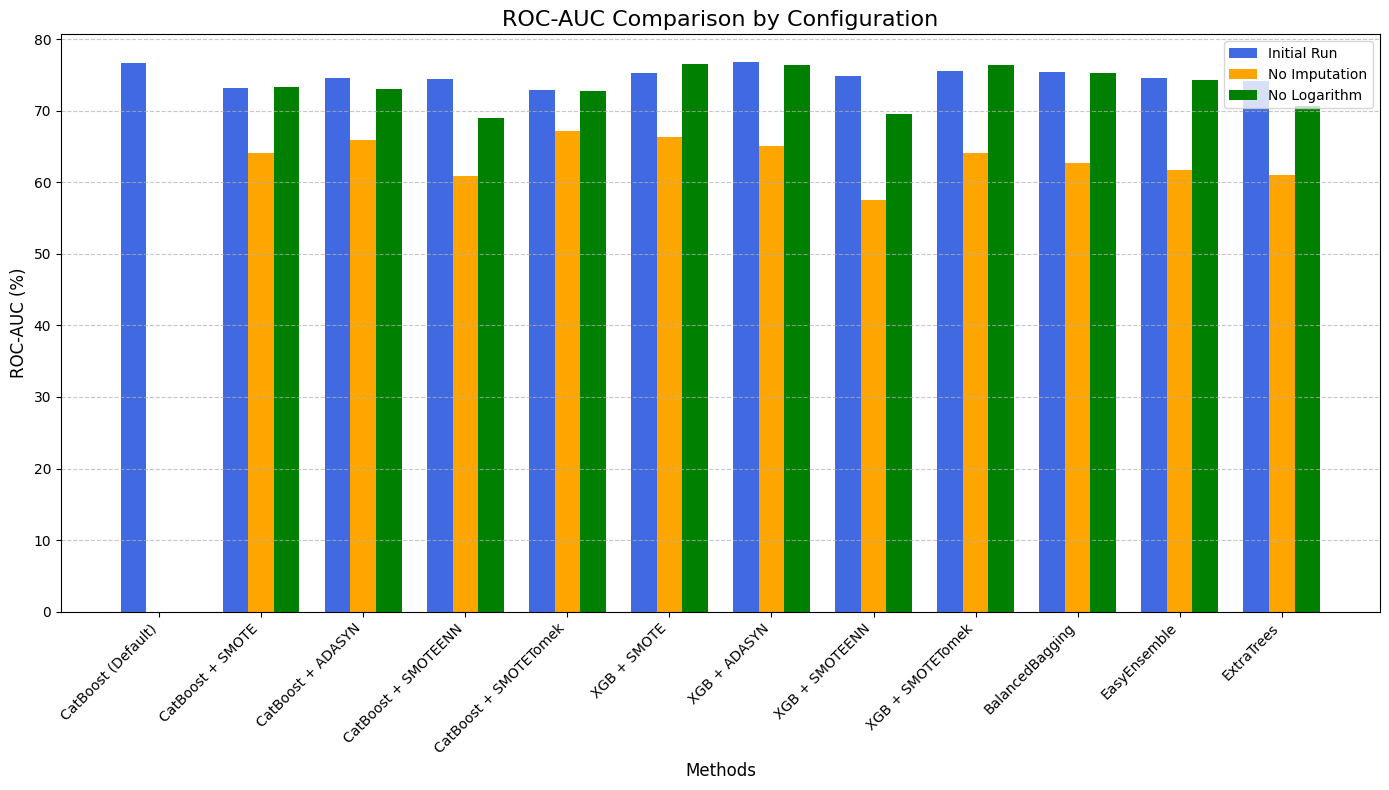

In [149]:
# Данные
data = {
    "Category": [
        "CatBoost (Default)",
        "CatBoost + SMOTE",
        "CatBoost + ADASYN",
        "CatBoost + SMOTEENN",
        "CatBoost + SMOTETomek",
        "XGB + SMOTE",
        "XGB + ADASYN",
        "XGB + SMOTEENN",
        "XGB + SMOTETomek",
        "BalancedBagging",
        "EasyEnsemble",
        "ExtraTrees",
    ],
    "Initial Run": [
        76.64,
        73.17,
        74.54,
        74.50,
        72.86,
        75.30,
        76.85,
        74.90,
        75.62,
        75.44,
        74.59,
        74.20,
    ],
    "No Imputation": [
        None,
        64.15,
        65.95,
        60.94,
        67.13,
        66.32,
        65.07,
        57.52,
        64.11,
        62.77,
        61.72,
        61.07,
    ],
    "No Logarithm": [
        None,
        73.37,
        73.01,
        69.04,
        72.81,
        76.52,
        76.40,
        69.54,
        76.37,
        75.32,
        74.26,
        70.71,
    ],
}

# Преобразуем данные в DataFrame
df = pd.DataFrame(data)

# Построение гистограммы
fig, ax = plt.subplots(figsize=(14, 8))

categories = df["Category"]
x = np.arange(len(categories))
bar_width = 0.25

# Значения для каждой группы
initial = df["Initial Run"]
no_imputation = df["No Imputation"]
no_logarithm = df["No Logarithm"]

# Построение столбцов
ax.bar(x - bar_width, initial, width=bar_width, label="Initial Run", color="royalblue")
ax.bar(x, no_imputation, width=bar_width, label="No Imputation", color="orange")
ax.bar(
    x + bar_width, no_logarithm, width=bar_width, label="No Logarithm", color="green"
)

# Настройки графика
ax.set_xlabel("Methods", fontsize=12)
ax.set_ylabel("ROC-AUC (%)", fontsize=12)
ax.set_title("ROC-AUC Comparison by Configuration", fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45, ha="right", fontsize=10)
ax.legend()

# Добавляем сетку
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Показываем график
plt.tight_layout()
plt.show()

**И ещё красивых выводов в ленту.**

### **Выводы по результатам экспериментов**

#### **1. Общие наблюдения**
- **Лучшие результаты достигаются в конфигурации `Initial Run`**, где использовались методы балансировки или настройки моделей без исключения данных и изменений (например, логарифмирования). Это говорит о том, что базовые данные лучше всего подходят для решения задачи при использовании оптимальных методов.
- **Методы балансировки снижают эффективность некоторых моделей**, особенно при применении более агрессивных способов обработки данных (например, без логарифмирования).

---

#### **2. Анализ по конфигурациям**

##### **Initial Run**
- **CatBoostClassifier с настройками по умолчанию** достигает наивысшего результата (76.64%), что подтверждает его силу как алгоритма, способного эффективно работать с несбалансированными данными без необходимости дополнительных методов.
- **XGBClassifier с ADASYN** показывает практически аналогичное качество (76.85%), что делает его отличной альтернативой при необходимости применять метод балансировки.
- **BalancedBaggingClassifier (75.44%)** и **EasyEnsembleClassifier (74.59%)** показывают хорошие результаты, но уступают CatBoost и XGB.

##### **No Imputation**
- Результаты резко ухудшаются по сравнению с конфигурацией `Initial Run`. Лучший показатель у **CatBoostClassifier с SMOTETomek** (67.13%), но это заметно ниже исходных 76.64%.
- **XGBClassifier с SMOTE (66.32%)** также показывает снижение качества, что указывает на значимость пропусков в данных.
- Методы ансамблей (BalancedBagging и EasyEnsemble) показывают средние результаты (~62%), а ExtraTreesClassifier демонстрирует наихудший результат (61.07%).

##### **No Logarithm**
- Удаление логарифмирования сказывается негативно, но меньше, чем исключение пропусков. Например:
  - **CatBoostClassifier с SMOTE (73.37%)** остаётся конкурентоспособным.
  - **XGBClassifier с SMOTE (76.52%)** и ADASYN (76.40%) сохраняют высокую эффективность, близкую к конфигурации `Initial Run`.
- Ансамбли всё ещё уступают бустингам, но сохраняют качество (BalancedBagging: 75.32%).

---

#### **3. Сравнение моделей**
- **CatBoostClassifier**:
  - Лидер в конфигурации `Initial Run` без дополнительных методов балансировки.
  - Устойчивость к изменениям данных делает его хорошим выбором для задач с несбалансированными классами.
- **XGBClassifier**:
  - Более чувствителен к методам синтетической балансировки.
  - Лучшие результаты достигаются с ADASYN и SMOTE, что делает его подходящим для задач, где требуется улучшить представление меньшего класса.
- **Ансамблевые методы (BalancedBagging и EasyEnsemble)**:
  - Надёжны, но уступают бустингам.
  - Хороший выбор, если требуется интерпретация или устойчивость к выбросам.
- **ExtraTreesClassifier**:
  - Устойчиво показывает низкие результаты, что говорит о его меньшей эффективности на данной выборке.

---

#### **4. Рекомендации**
1. **Для наиболее высокой точности**:
   - Используй **CatBoostClassifier с настройками по умолчанию** (без обработки данных).
   - Если предпочтителен другой алгоритм, применяй **XGBClassifier с ADASYN**.

2. **Если данные требуют обработки**:
   - Избегай пропусков — конфигурация `No Imputation` значительно снижает качество.
   - Логарифмирование признаков полезно для устранения скоса распределения, особенно при больших вариациях в данных.

3. **Для устойчивости к дисбалансу**:
   - Рассмотри **BalancedBaggingClassifier** как надёжный вариант, если важны интерпретация и простота.

4. **Исключить ExtraTreesClassifier** из дальнейших экспериментов на данной задаче, так как его качество значительно ниже.